In [1]:
import sys

PACKAGE_PARENT = '..'
sys.path.append(PACKAGE_PARENT)

In [2]:
%matplotlib inline

import os
import json
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler

from gaminet import GAMINet
from gaminet.utils import local_visualize
from gaminet.utils import global_visualize_density
from gaminet.utils import global_visualize_wo_density
from gaminet.utils import feature_importance_visualize
from gaminet.utils import plot_regularization
from gaminet.utils import plot_trajectory

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [3]:
def metric_wrapper(metric, scaler):
    def wrapper(label, pred):
        return metric(label, pred, scaler=scaler)
    return wrapper

def rmse(label, pred, scaler):
    pred = scaler.inverse_transform(pred.reshape([-1, 1]))
    label = scaler.inverse_transform(label.reshape([-1, 1]))
    return np.sqrt(np.mean((pred - label)**2))

def load_ch():
    
    from sklearn.datasets import fetch_california_housing
    cal_housing = fetch_california_housing()
    x, y = cal_housing.data, cal_housing.target.reshape(-1, 1)

    task_type = "Regression"
    meta_info = {cal_housing.feature_names[i]:{'type':'continuous'} for i in range(x.shape[1])}
    meta_info.update({'Y':{'type':'target'}})         
    return x, y, task_type, meta_info

def load_regression_data(name):
    func_dict = {'ch':load_ch}
    def wrapper(random_state):
        function_name_ = func_dict[name]
        x, y, task_type, meta_info = function_name_()
        xx = np.zeros((x.shape[0], x.shape[1]), dtype=np.float32)
        for i, (key, item) in enumerate(meta_info.items()):
            if item['type'] == 'target':
                sy = MinMaxScaler((0, 1))
                y = sy.fit_transform(y)
                meta_info[key]['scaler'] = sy
            else:
                sx = MinMaxScaler((0, 1))
                xx[:,[i]] = sx.fit_transform(x[:,[i]])
                meta_info[key]['scaler'] = sx
        train_x, test_x, train_y, test_y = train_test_split(xx.astype(np.float32), y,
                                                            test_size=0.2, random_state=random_state)
        return train_x, test_x, train_y, test_y, task_type, meta_info, metric_wrapper(rmse, sy)
    return wrapper

In [4]:
random_state = 0
data_loader = load_regression_data("ch")
train_x, test_x, train_y, test_y, task_type, meta_info, get_metric = data_loader(random_state)

In [5]:
meta_info.keys()

dict_keys(['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude', 'Y'])

####################GAMI-Net training start.####################
##########Stage 1: main effect training start.##########
Main effects training epoch: 1, train loss: 0.04444, val loss: 0.04429
Main effects training epoch: 2, train loss: 0.02601, val loss: 0.02680
Main effects training epoch: 3, train loss: 0.02486, val loss: 0.02542
Main effects training epoch: 4, train loss: 0.02347, val loss: 0.02410
Main effects training epoch: 5, train loss: 0.02236, val loss: 0.02290
Main effects training epoch: 6, train loss: 0.02147, val loss: 0.02192
Main effects training epoch: 7, train loss: 0.02110, val loss: 0.02152
Main effects training epoch: 8, train loss: 0.02084, val loss: 0.02107
Main effects training epoch: 9, train loss: 0.02067, val loss: 0.02099
Main effects training epoch: 10, train loss: 0.02073, val loss: 0.02110
Main effects training epoch: 11, train loss: 0.02033, val loss: 0.02057
Main effects training epoch: 12, train loss: 0.02019, val loss: 0.02027
Main effects training e

Main effects training epoch: 115, train loss: 0.01451, val loss: 0.01466
Main effects training epoch: 116, train loss: 0.01454, val loss: 0.01450
Main effects training epoch: 117, train loss: 0.01442, val loss: 0.01442
Main effects training epoch: 118, train loss: 0.01517, val loss: 0.01519
Main effects training epoch: 119, train loss: 0.01465, val loss: 0.01458
Main effects training epoch: 120, train loss: 0.01482, val loss: 0.01490
Main effects training epoch: 121, train loss: 0.01479, val loss: 0.01474
Main effects training epoch: 122, train loss: 0.01533, val loss: 0.01533
Main effects training epoch: 123, train loss: 0.01450, val loss: 0.01457
Main effects training epoch: 124, train loss: 0.01454, val loss: 0.01449
Main effects training epoch: 125, train loss: 0.01442, val loss: 0.01445
Main effects training epoch: 126, train loss: 0.01431, val loss: 0.01431
Main effects training epoch: 127, train loss: 0.01434, val loss: 0.01437
Main effects training epoch: 128, train loss: 0.014

Main effects training epoch: 228, train loss: 0.01475, val loss: 0.01483
Main effects training epoch: 229, train loss: 0.01404, val loss: 0.01404
Main effects training epoch: 230, train loss: 0.01400, val loss: 0.01410
Main effects training epoch: 231, train loss: 0.01404, val loss: 0.01402
Main effects training epoch: 232, train loss: 0.01428, val loss: 0.01434
Main effects training epoch: 233, train loss: 0.01402, val loss: 0.01396
Main effects training epoch: 234, train loss: 0.01433, val loss: 0.01434
Main effects training epoch: 235, train loss: 0.01404, val loss: 0.01407
Main effects training epoch: 236, train loss: 0.01408, val loss: 0.01411
Main effects training epoch: 237, train loss: 0.01403, val loss: 0.01410
Main effects training epoch: 238, train loss: 0.01426, val loss: 0.01433
Main effects training epoch: 239, train loss: 0.01453, val loss: 0.01449
Main effects training epoch: 240, train loss: 0.01411, val loss: 0.01410
Main effects training epoch: 241, train loss: 0.013

Main effects training epoch: 342, train loss: 0.01393, val loss: 0.01393
Main effects training epoch: 343, train loss: 0.01387, val loss: 0.01391
Main effects training epoch: 344, train loss: 0.01539, val loss: 0.01532
Main effects training epoch: 345, train loss: 0.01399, val loss: 0.01404
Main effects training epoch: 346, train loss: 0.01381, val loss: 0.01379
Main effects training epoch: 347, train loss: 0.01422, val loss: 0.01434
Main effects training epoch: 348, train loss: 0.01524, val loss: 0.01522
Main effects training epoch: 349, train loss: 0.01458, val loss: 0.01462
Main effects training epoch: 350, train loss: 0.01380, val loss: 0.01369
Main effects training epoch: 351, train loss: 0.01390, val loss: 0.01391
Main effects training epoch: 352, train loss: 0.01410, val loss: 0.01406
Main effects training epoch: 353, train loss: 0.01410, val loss: 0.01408
Main effects training epoch: 354, train loss: 0.01380, val loss: 0.01374
Main effects training epoch: 355, train loss: 0.014

Interaction training epoch: 53, train loss: 0.01293, val loss: 0.01323
Interaction training epoch: 54, train loss: 0.01285, val loss: 0.01313
Interaction training epoch: 55, train loss: 0.01287, val loss: 0.01316
Interaction training epoch: 56, train loss: 0.01283, val loss: 0.01311
Interaction training epoch: 57, train loss: 0.01283, val loss: 0.01310
Interaction training epoch: 58, train loss: 0.01286, val loss: 0.01314
Interaction training epoch: 59, train loss: 0.01285, val loss: 0.01315
Interaction training epoch: 60, train loss: 0.01282, val loss: 0.01308
Interaction training epoch: 61, train loss: 0.01298, val loss: 0.01332
Interaction training epoch: 62, train loss: 0.01292, val loss: 0.01322
Interaction training epoch: 63, train loss: 0.01282, val loss: 0.01311
Interaction training epoch: 64, train loss: 0.01286, val loss: 0.01316
Interaction training epoch: 65, train loss: 0.01300, val loss: 0.01328
Interaction training epoch: 66, train loss: 0.01287, val loss: 0.01315
Intera

Interaction training epoch: 168, train loss: 0.01230, val loss: 0.01273
Interaction training epoch: 169, train loss: 0.01231, val loss: 0.01280
Interaction training epoch: 170, train loss: 0.01233, val loss: 0.01273
Interaction training epoch: 171, train loss: 0.01232, val loss: 0.01281
Interaction training epoch: 172, train loss: 0.01227, val loss: 0.01277
Interaction training epoch: 173, train loss: 0.01235, val loss: 0.01280
Interaction training epoch: 174, train loss: 0.01233, val loss: 0.01283
Interaction training epoch: 175, train loss: 0.01226, val loss: 0.01276
Interaction training epoch: 176, train loss: 0.01246, val loss: 0.01295
Interaction training epoch: 177, train loss: 0.01225, val loss: 0.01275
Interaction training epoch: 178, train loss: 0.01228, val loss: 0.01276
Interaction training epoch: 179, train loss: 0.01247, val loss: 0.01294
Interaction training epoch: 180, train loss: 0.01226, val loss: 0.01274
Interaction training epoch: 181, train loss: 0.01224, val loss: 

Interaction training epoch: 282, train loss: 0.01174, val loss: 0.01234
Interaction training epoch: 283, train loss: 0.01188, val loss: 0.01244
Interaction training epoch: 284, train loss: 0.01195, val loss: 0.01261
Interaction training epoch: 285, train loss: 0.01180, val loss: 0.01242
Interaction training epoch: 286, train loss: 0.01177, val loss: 0.01235
Interaction training epoch: 287, train loss: 0.01175, val loss: 0.01233
Interaction training epoch: 288, train loss: 0.01223, val loss: 0.01282
Interaction training epoch: 289, train loss: 0.01180, val loss: 0.01244
Interaction training epoch: 290, train loss: 0.01179, val loss: 0.01234
Interaction training epoch: 291, train loss: 0.01175, val loss: 0.01235
Interaction training epoch: 292, train loss: 0.01186, val loss: 0.01242
Interaction training epoch: 293, train loss: 0.01177, val loss: 0.01237
Interaction training epoch: 294, train loss: 0.01211, val loss: 0.01266
Interaction training epoch: 295, train loss: 0.01195, val loss: 

Interaction training epoch: 396, train loss: 0.01164, val loss: 0.01222
Interaction training epoch: 397, train loss: 0.01162, val loss: 0.01218
Interaction training epoch: 398, train loss: 0.01161, val loss: 0.01220
Interaction training epoch: 399, train loss: 0.01182, val loss: 0.01237
Interaction training epoch: 400, train loss: 0.01152, val loss: 0.01212
Interaction training epoch: 401, train loss: 0.01169, val loss: 0.01222
Interaction training epoch: 402, train loss: 0.01154, val loss: 0.01210
Interaction training epoch: 403, train loss: 0.01165, val loss: 0.01230
Interaction training epoch: 404, train loss: 0.01156, val loss: 0.01218
Interaction training epoch: 405, train loss: 0.01166, val loss: 0.01224
Interaction training epoch: 406, train loss: 0.01154, val loss: 0.01212
Interaction training epoch: 407, train loss: 0.01167, val loss: 0.01232
Interaction training epoch: 408, train loss: 0.01163, val loss: 0.01219
Interaction training epoch: 409, train loss: 0.01153, val loss: 

Interaction training epoch: 510, train loss: 0.01160, val loss: 0.01218
Interaction training epoch: 511, train loss: 0.01149, val loss: 0.01204
Interaction training epoch: 512, train loss: 0.01215, val loss: 0.01277
Interaction training epoch: 513, train loss: 0.01185, val loss: 0.01241
Interaction training epoch: 514, train loss: 0.01158, val loss: 0.01212
Interaction training epoch: 515, train loss: 0.01145, val loss: 0.01199
Interaction training epoch: 516, train loss: 0.01158, val loss: 0.01221
Interaction training epoch: 517, train loss: 0.01181, val loss: 0.01237
Interaction training epoch: 518, train loss: 0.01188, val loss: 0.01245
Interaction training epoch: 519, train loss: 0.01154, val loss: 0.01209
Interaction training epoch: 520, train loss: 0.01157, val loss: 0.01210
Interaction training epoch: 521, train loss: 0.01157, val loss: 0.01219
Interaction training epoch: 522, train loss: 0.01178, val loss: 0.01236
Interaction training epoch: 523, train loss: 0.01153, val loss: 

Interaction training epoch: 624, train loss: 0.01140, val loss: 0.01194
Interaction training epoch: 625, train loss: 0.01154, val loss: 0.01215
Interaction training epoch: 626, train loss: 0.01139, val loss: 0.01198
Interaction training epoch: 627, train loss: 0.01144, val loss: 0.01203
Interaction training epoch: 628, train loss: 0.01141, val loss: 0.01202
Interaction training epoch: 629, train loss: 0.01147, val loss: 0.01210
Interaction training epoch: 630, train loss: 0.01140, val loss: 0.01200
Interaction training epoch: 631, train loss: 0.01154, val loss: 0.01218
Interaction training epoch: 632, train loss: 0.01139, val loss: 0.01199
Interaction training epoch: 633, train loss: 0.01154, val loss: 0.01212
Interaction training epoch: 634, train loss: 0.01134, val loss: 0.01194
Interaction training epoch: 635, train loss: 0.01150, val loss: 0.01211
Interaction training epoch: 636, train loss: 0.01138, val loss: 0.01204
Interaction training epoch: 637, train loss: 0.01178, val loss: 

Interaction training epoch: 738, train loss: 0.01146, val loss: 0.01206
Interaction training epoch: 739, train loss: 0.01144, val loss: 0.01203
Interaction training epoch: 740, train loss: 0.01127, val loss: 0.01190
Interaction training epoch: 741, train loss: 0.01139, val loss: 0.01201
Interaction training epoch: 742, train loss: 0.01143, val loss: 0.01212
Early stop at epoch 742, with validation loss: 0.01212
##########Stage 2: interaction training stop.##########
Fine tuning epoch: 1, train loss: 0.01138, val loss: 0.01200
Fine tuning epoch: 2, train loss: 0.01144, val loss: 0.01207
Fine tuning epoch: 3, train loss: 0.01153, val loss: 0.01215
Fine tuning epoch: 4, train loss: 0.01155, val loss: 0.01209
Fine tuning epoch: 5, train loss: 0.01159, val loss: 0.01226
Fine tuning epoch: 6, train loss: 0.01189, val loss: 0.01233
Fine tuning epoch: 7, train loss: 0.01217, val loss: 0.01288
Fine tuning epoch: 8, train loss: 0.01197, val loss: 0.01247
Fine tuning epoch: 9, train loss: 0.01143

Fine tuning epoch: 126, train loss: 0.01138, val loss: 0.01193
Fine tuning epoch: 127, train loss: 0.01158, val loss: 0.01215
Fine tuning epoch: 128, train loss: 0.01112, val loss: 0.01173
Fine tuning epoch: 129, train loss: 0.01104, val loss: 0.01173
Fine tuning epoch: 130, train loss: 0.01150, val loss: 0.01212
Fine tuning epoch: 131, train loss: 0.01142, val loss: 0.01207
Fine tuning epoch: 132, train loss: 0.01124, val loss: 0.01192
Fine tuning epoch: 133, train loss: 0.01170, val loss: 0.01230
Fine tuning epoch: 134, train loss: 0.01148, val loss: 0.01201
Fine tuning epoch: 135, train loss: 0.01121, val loss: 0.01182
Fine tuning epoch: 136, train loss: 0.01235, val loss: 0.01288
Fine tuning epoch: 137, train loss: 0.01104, val loss: 0.01167
Fine tuning epoch: 138, train loss: 0.01128, val loss: 0.01183
Fine tuning epoch: 139, train loss: 0.01123, val loss: 0.01190
Fine tuning epoch: 140, train loss: 0.01230, val loss: 0.01296
Fine tuning epoch: 141, train loss: 0.01115, val loss: 

Fine tuning epoch: 257, train loss: 0.01111, val loss: 0.01181
Fine tuning epoch: 258, train loss: 0.01093, val loss: 0.01153
Fine tuning epoch: 259, train loss: 0.01160, val loss: 0.01227
Fine tuning epoch: 260, train loss: 0.01112, val loss: 0.01189
Fine tuning epoch: 261, train loss: 0.01111, val loss: 0.01177
Fine tuning epoch: 262, train loss: 0.01146, val loss: 0.01217
Fine tuning epoch: 263, train loss: 0.01210, val loss: 0.01285
Fine tuning epoch: 264, train loss: 0.01127, val loss: 0.01198
Fine tuning epoch: 265, train loss: 0.01149, val loss: 0.01221
Fine tuning epoch: 266, train loss: 0.01104, val loss: 0.01172
Fine tuning epoch: 267, train loss: 0.01096, val loss: 0.01165
Fine tuning epoch: 268, train loss: 0.01096, val loss: 0.01168
Fine tuning epoch: 269, train loss: 0.01101, val loss: 0.01172
Fine tuning epoch: 270, train loss: 0.01165, val loss: 0.01241
Fine tuning epoch: 271, train loss: 0.01103, val loss: 0.01164
Fine tuning epoch: 272, train loss: 0.01108, val loss: 

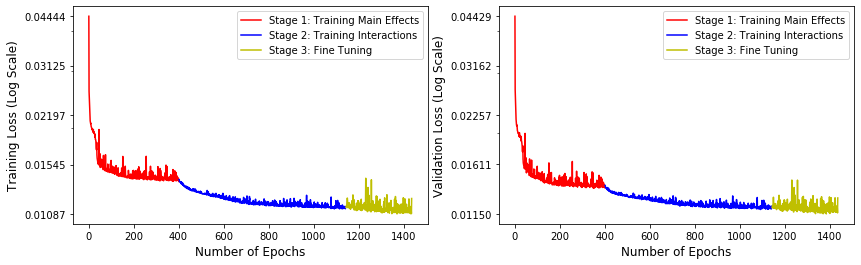

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


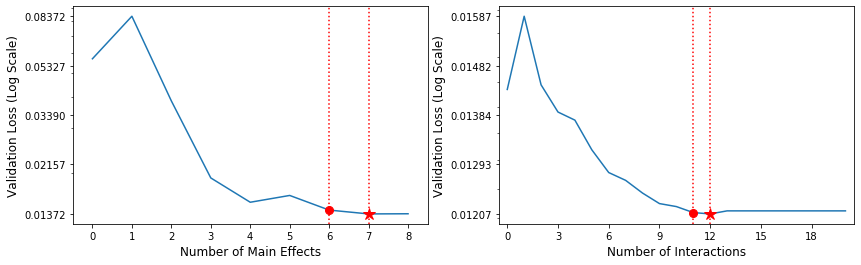

In [6]:
folder = "./results/"
if not os.path.exists(folder):
    os.makedirs(folder)

model = GAMINet(meta_info=meta_info, interact_num=20,
            interact_arch=[40] * 1, subnet_arch=[40] * 2, 
            batch_size=200, task_type=task_type, activation_func=tf.nn.relu, 
            main_effect_epochs=5000, interaction_epochs=5000, tuning_epochs=500, 
            lr_bp=[0.001, 0.001, 0.001], early_stop_thres=[50, 50, 50],
            heredity=True, loss_threshold=0.01, reg_clarity=0.1,
            verbose=True, val_ratio=0.2, random_state=0)
model.fit(train_x, train_y)
data_dict_logs = model.summary_logs(save_dict=False)
plot_trajectory(data_dict_logs, folder=folder, name="ch_traj", save_png=True, save_eps=True)
plot_regularization(data_dict_logs, folder=folder, name="ch_regu", save_png=True, save_eps=True)

In [7]:
pred_train = model.predict(train_x)
pred_test = model.predict(test_x)
gaminet_stat = np.hstack([np.round(get_metric(train_y, pred_train),5),
                      np.round(get_metric(test_y, pred_test),5)])
print(gaminet_stat)

[0.53717 0.54939]


Global Interpretation

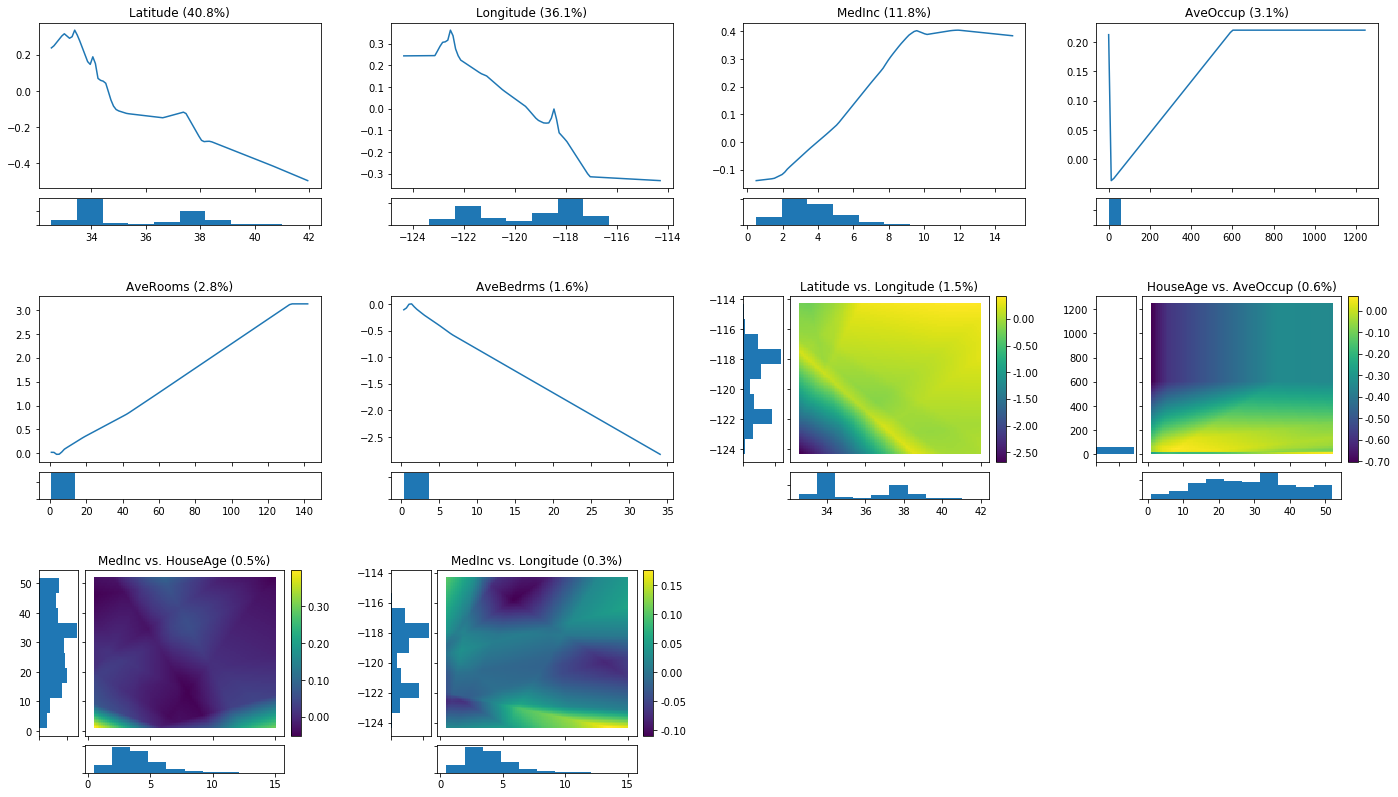

In [8]:
data_dict_global = model.global_explain(save_dict=True, folder=folder, name="ch_global")
global_visualize_density(data_dict_global, folder=folder, name="ch_global",
                         main_effect_num=8, interaction_num=4, cols_per_row=4, save_png=True, save_eps=True)

Feature Importance

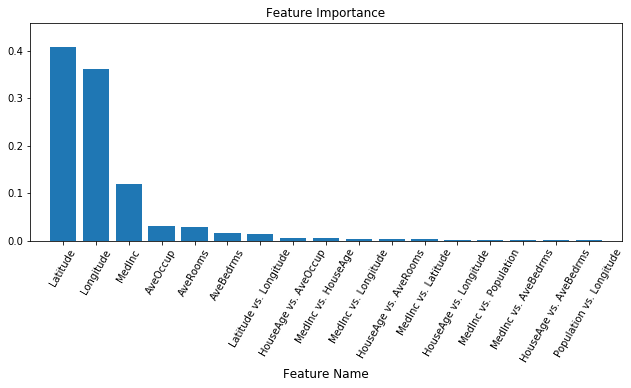

In [9]:
feature_importance_visualize(data_dict_global)

Interpret the prediction of a test sample

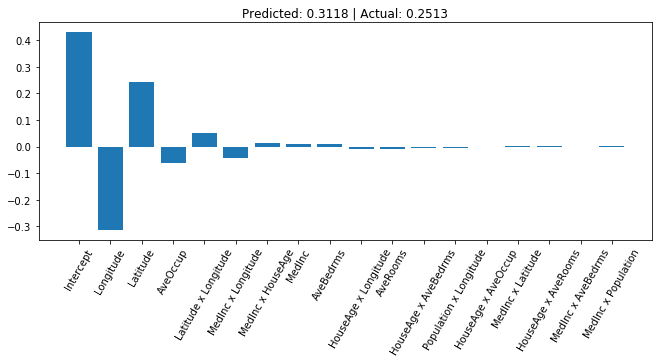

In [10]:
data_dict_local = model.local_explain(test_x[[0]], test_y[[0]], save_dict=False)
local_visualize(data_dict_local[0], save_png=False)